<a href="https://colab.research.google.com/github/Jathurshan0330/Image-Registration-ITK/blob/master/170248G_Image_Registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Requirements

In [1]:
from IPython.display import clear_output

In [2]:
!pip install itk itkwidgets ipywidgets
clear_output()

In [3]:
#Import Libraries
import sys
from distutils.version import StrictVersion as VS
import itk
import numpy as np
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from seaborn.matrix import clustermap

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
if VS(itk.Version.GetITKVersion()) < VS("4.9.0"):
    print("ITK 4.9.0 is required.")
    sys.exit(1)

In [6]:
def plotting_images(img_list,title_list, cmap = 'gray'):
  fig, ax = plt.subplots(1,len(img_list), figsize=(20,8))
  for i in range(len(img_list)):
    ax[i].imshow(img_list[i], cmap = cmap, interpolation ='bilinear'), 
    ax[i].set_title(title_list[i],fontsize = 15),ax[i].axis('off')
  plt.show()

In [7]:
def interactive_plot(img_list,title_list, cmap = 'gray'):
  def plotting_images(slice):
    fig, ax = plt.subplots(1,len(img_list), figsize=(20,8))
    for i in range(len(img_list)):
      ax[i].imshow(img_list[i][slice], cmap = cmap, interpolation ='bilinear'), 
      ax[i].set_title(title_list[i],fontsize = 15),ax[i].axis('off')
    plt.show()
  select_slice = IntSlider(min=0, max=img_list[0].shape[0]-1, description='Select Slice', continuous_update=False)
  return interactive(plotting_images, slice=select_slice)


# Load Images 

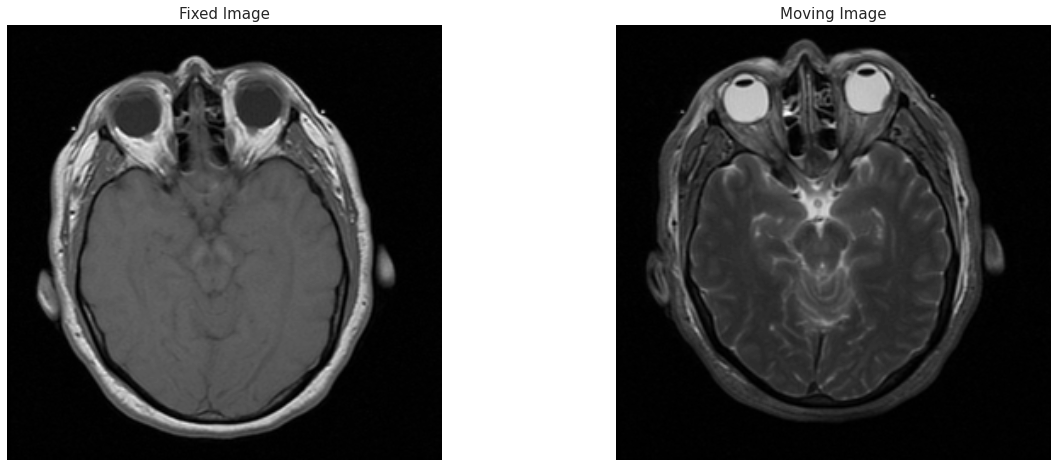

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=32), Output(…

In [8]:
base = "/content/drive/MyDrive/Registration Data/"
fixed_image_file = base+"VF-MRT1-1014-1174.vtk"
moving_image_file = base+"VF-MRT2-1014-1174.vtk"


fixed_image = itk.imread(fixed_image_file)
moving_image = itk.imread(moving_image_file)

slice = 20
plotting_images([fixed_image[slice],moving_image[slice]],["Fixed Image", "Moving Image"])
interactive_plot([fixed_image,moving_image],["Fixed Image", "Moving Image"])

# Image Registration

In [12]:
#Images and Output files
pixel_type = itk.F
fixed_image_file = base+"VF-MRT1-1014-1174.vtk"
moving_image_file = base+"VF-MRT2-1014-1174.vtk"
reg_image_file_trans  = base+"reg_trans.vtk"
# output_image_file_trans  = base+"out_trans.vtk"
diff_img_before_file_trans = base+"img_before_trans.vtk"
diff_img_after_file_trans  = base+"img_after_trans.vtk"

fixed_img = itk.imread(fixed_image_file, pixel_type)
moving_img = itk.imread(moving_image_file, pixel_type)

dim = fixed_img.GetImageDimension()
fixed_img_type = itk.Image[pixel_type, dim]
moving_img_type = itk.Image[pixel_type, dim]

print("Fixed Image ====================>")
print(f"Shape       : {fixed_img.shape} ")
print(f"Pixel Type  : {fixed_img_type} ")
print("Moving Image ===================>")
print(f"Shape       : {moving_img.shape} ")
print(f"Pixel Type  : {moving_img_type} ")

Fixed Image ====================>
Shape       : (33, 256, 256) 
Pixel Type  : <class 'itk.itkImagePython.itkImageF3'> 
Moving Image ===================>
Shape       : (63, 256, 256) 
Pixel Type  : <class 'itk.itkImagePython.itkImageF3'> 


In [129]:
########################### Transformation ###########################
transform_type = itk.TranslationTransform[itk.D,dim]
initial_transform = transform_type.New()

########################### Interpolator ###########################
interpolator_type = itk.LinearInterpolateImageFunction[fixed_img_type, itk.D]
fixed_interp = interpolator_type.New()
moving_interp = interpolator_type.New()

############################# Optimizer ##############################
opt = itk.RegularStepGradientDescentOptimizerv4.New( LearningRate=4,        ###
                                                    MinimumStepLength=0.0005,###
                                                    RelaxationFactor=0.5,   ###
                                                    NumberOfIterations=200) ###

############################## Metric ##################################
metric = itk.MattesMutualInformationImageToImageMetricv4[fixed_img_type, moving_img_type].New()
metric.SetNumberOfHistogramBins(24)  ####
metric.SetUseMovingImageGradientFilter(False)
metric.SetUseFixedImageGradientFilter(False)
metric.SetFixedInterpolator(fixed_interp)
metric.SetMovingInterpolator(moving_interp)
########################### Registration ###############################
reg = itk.ImageRegistrationMethodv4[fixed_img_type, moving_img_type].New( FixedImage = fixed_img, 
                                                                          MovingImage = moving_img,
                                                                          Metric = metric, Optimizer=opt, 
                                                                          InitialTransform=initial_transform)


In [130]:
movingInitialTransform = transform_type.New()
initialParameters = movingInitialTransform.GetParameters()
initialParameters[0] = 0
initialParameters[1] = 0
initialParameters[2] = 0
movingInitialTransform.SetParameters(initialParameters)
reg.SetMovingInitialTransform(movingInitialTransform)



identityTransform = transform_type.New()
identityTransform.SetIdentity()
reg.SetFixedInitialTransform(identityTransform)

#------------------------------------
reg.SetNumberOfLevels(1)                  ###
reg.SetSmoothingSigmasPerLevel([0])       ###
reg.SetShrinkFactorsPerLevel([1])         ###
#------------------------------------



 Starting Registration ===========================>
Index : 0 -->  Metric : -0.363855   Translation : (0.256409 -3.813188 -1.180615)
Index : 1 -->  Metric : -0.470647   Translation : (0.366235 -7.714076 -2.058688)
Index : 2 -->  Metric : -0.628557   Translation : (-1.687360 -11.044031 -1.225537)
Index : 3 -->  Metric : -0.537375   Translation : (-0.179787 -9.731233 -1.164040)
Index : 4 -->  Metric : -0.609955   Translation : (0.170345 -7.762874 -1.109538)
Index : 5 -->  Metric : -0.632928   Translation : (0.065918 -8.747871 -1.246928)
Index : 6 -->  Metric : -0.641698   Translation : (0.084300 -8.248325 -1.257681)
Index : 7 -->  Metric : -0.646847   Translation : (0.126899 -8.487026 -1.318566)
Index : 8 -->  Metric : -0.645818   Translation : (0.088192 -8.368174 -1.319516)
Index : 9 -->  Metric : -0.647018   Translation : (0.118975 -8.249137 -1.342046)
Index : 10 -->  Metric : -0.647313   Translation : (0.104698 -8.309891 -1.345408)
Index : 11 -->  Metric : -0.647392   Translation : (0

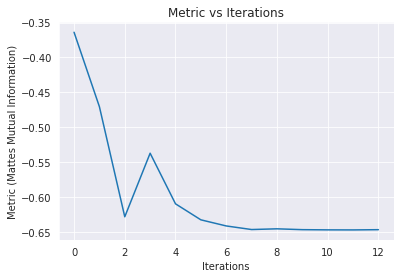

<Figure size 432x288 with 0 Axes>

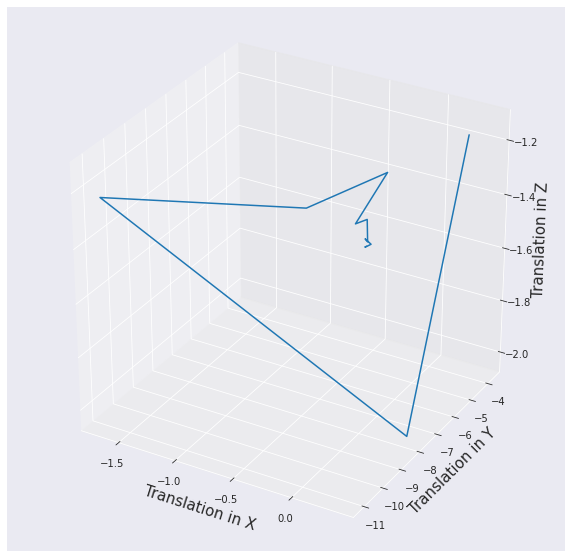

In [131]:
from seaborn import axisgrid
iter = []
val = []
x = []
y = []
z = []
def iterationUpdate():
    currentParameter = reg.GetTransform().GetParameters()
    iter.append(opt.GetCurrentIteration())
    val.append(opt.GetValue())
    x.append(reg.GetTransform().GetParameters().GetElement(0))
    y.append(reg.GetTransform().GetParameters().GetElement(1))
    z.append(reg.GetTransform().GetParameters().GetElement(2))
    print(
        "Index : %i -->  Metric : %f   Translation : (%f %f %f)"
        % (
            opt.GetCurrentIteration(),
            opt.GetValue(),
            currentParameter.GetElement(0),
            currentParameter.GetElement(1),
            currentParameter.GetElement(2),

        )
    )
    
iterationCommand = itk.PyCommand.New()
iterationCommand.SetCommandCallable(iterationUpdate)
opt.AddObserver(itk.IterationEvent(), iterationCommand)

print(" Starting Registration ===========================>")
reg.Update()
print(" Registration Completed ===========================>")




transform = reg.GetTransform()
finalParameters = transform.GetParameters()
translationAlongX = finalParameters.GetElement(0)
translationAlongY = finalParameters.GetElement(1)
translationAlongZ = finalParameters.GetElement(2)

numberOfIterations = opt.GetCurrentIteration()

bestValue = opt.GetValue()

print("Result:")
print(f" Translation (X)    : {translationAlongX}")
print(f" Translation (Y)    : {translationAlongY}")
print(f" Translation (Z)    : {translationAlongZ}")
print(f" Num of Iterations  : {numberOfIterations}")
print(f" Metric value       : {bestValue}")
print("=============================================>")


plt.figure()
plt.plot(iter, val)
plt.xlabel("Iterations")
plt.ylabel("Metric (Mattes Mutual Information)")
plt.title("Metric vs Iterations")
plt.show()

plt.figure()


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure( figsize=(10,10)).add_subplot(projection='3d')
ax.plot(x,y,z)
ax.set_xlabel("Translation in X",fontsize = 15)
ax.set_ylabel("Translation in Y",fontsize = 15)
ax.set_zlabel("Translation in Z",fontsize = 15)
plt.show()

In [114]:
CompositeTransformType = itk.CompositeTransform[itk.D, dim]
outputCompositeTransform = CompositeTransformType.New()
outputCompositeTransform.AddTransform(movingInitialTransform)
outputCompositeTransform.AddTransform(reg.GetModifiableTransform())

resampler = itk.ResampleImageFilter.New(Input = moving_img,
                                        Transform = outputCompositeTransform,
                                        UseReferenceImage = True,
                                        ReferenceImage = fixed_img)
resampler.SetDefaultPixelValue(100)

OutputPixelType = itk.F#ctype('unsigned char')
OutputImageType = itk.Image[OutputPixelType, dim]

caster = itk.CastImageFilter[fixed_img_type,
        OutputImageType].New(Input = resampler)

writer = itk.ImageFileWriter.New(Input=caster, FileName=reg_image_file_trans)
writer.SetFileName(reg_image_file_trans)
writer.Update()

difference = itk.SubtractImageFilter.New(Input1 = fixed_img,
                                         Input2 = resampler)

intensityRescaler = itk.RescaleIntensityImageFilter[fixed_img_type,
                    OutputImageType].New(
                        Input=difference,
                        OutputMinimum=itk.NumericTraits[OutputPixelType].min(),
                        OutputMaximum=itk.NumericTraits[OutputPixelType].max())

resampler.SetDefaultPixelValue(1)
writer.SetInput(intensityRescaler.GetOutput())
writer.SetFileName(diff_img_after_file_trans)
writer.Update()

resampler.SetTransform(identityTransform)
writer.SetFileName(diff_img_before_file_trans)
writer.Update()



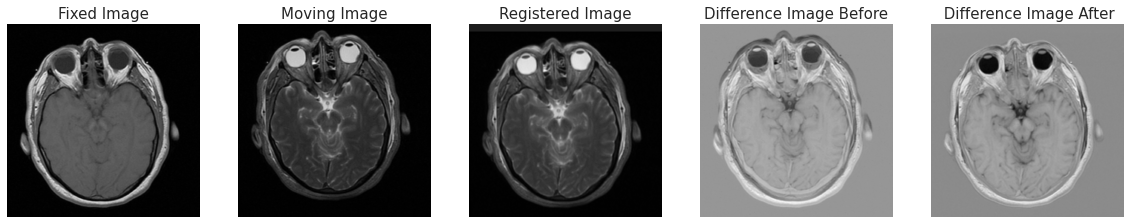

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=32), Output(…

In [115]:
reg_image_trans = itk.imread(reg_image_file_trans)
img_before_trans = itk.imread(diff_img_before_file_trans)
img_after_trans = itk.imread(diff_img_after_file_trans)

plotting_images([fixed_image[slice],moving_image[slice],reg_image_trans[slice],img_before_trans[slice],img_after_trans[slice]],
                ["Fixed Image", "Moving Image","Registered Image","Difference Image Before"," Difference Image After"])

interactive_plot([fixed_image,moving_image,reg_image_trans,img_before_trans,img_after_trans],
                ["Fixed Image", "Moving Image","Registered Image","Difference Image Before","Difference Image After"])

In [116]:
def get_merged_img(img1, img2,num_regions = 4):
  img_new = itk.array_from_image(img1)
  if img1.shape[0]!=img2.shape[0]:
    img2 = itk.image_from_array(img2[:img1.shape[0]])
  size = img1.shape[-1]//num_regions
  for i in range (num_regions):
    for j in range(num_regions):
      if (i+j)%2 == 1:
        img_new[:,i*size:(i+1)*size,j*size:(j+1)*size] = itk.array_from_image(img2)[:,i*size:(i+1)*size,j*size:(j+1)*size]

  return img_new

In [117]:
before_img = get_merged_img(fixed_image, moving_image,num_regions = 2)
aft_img = get_merged_img(fixed_image, reg_image_trans,num_regions = 2)

before_img2 = get_merged_img(fixed_image, moving_image,num_regions = 4)
aft_img2 = get_merged_img(fixed_image, reg_image_trans,num_regions = 4)

interactive_plot([fixed_image,moving_image, before_img,aft_img,before_img2,aft_img2],
                ["Fixed Image", "Moving Image","Before Registration", "After Registration", "Before Registration", "After Registration"])

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=32), Output(…

In [118]:
from matplotlib.animation import FuncAnimation
from IPython import display
def interactive_gif_data(img, cmap = 'gray'):
  """
  Interactive tool to visualize the dataset as gif. 
  """
  def Animate():
    Figure = plt.figure() 
    # creating a plot
    imgs_plotted = plt.imshow(img[0,:,:], cmap = 'gray') 
    plt.axis("off")

    def AnimationFunction(frame):
        y = img[frame,:,:]
    
        # line is set with new values of x and y
        imgs_plotted.set_data(y)

    anim_created = FuncAnimation(Figure, AnimationFunction, frames=img.shape[0]-1, interval=200)

    video = anim_created.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    # plt.show()
  # good practice to close the plt object.
    plt.close()

  return interactive(Animate)


In [119]:
interactive_gif_data(before_img2)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [120]:
interactive_gif_data(aft_img2)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [121]:
interactive_gif_data(before_img)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [122]:
interactive_gif_data(aft_img)

interactive(children=(Output(),), _dom_classes=('widget-interact',))